## <span style="color:white">Data Science Immersive Capstone Project</span>
### <span style="color:#CCC">Chris Huber, chrishubersf@gmail.com</span>
#### <span style="color:#AAA">A predictive study of edible wild mushroom growth in the greater San Francisco Bay Area</span>

### <span style="color:white">Problem Statement</span>
<div style="margin-left: 30px; margin-right: 30px;">
<p>Given prior data records of findings of edible wild edible mushroom species with latitude/longitude coordinates, species names, dates of sightings, weather conditions, <strikethrough>substrate composition</strikethrough>, and other relevant factors can I predict for a given period the likelihood of finding certain species of mushrooms that grow natively in the Bay Area.</p>
</div>

#### Add modeling hows/steps/flowchart? (going forward)
#### Visualizations

### <span style="color:white">Proposed Methods and Models</span>
<div style="margin-left: 30px; margin-right: 30px;">
<p>I propose to use MySQL as a database backend and Python/Pandas as the main technologies to analyze and deliver my findings</p>
<p>Sourcing the data is tricky: the records I have been able to find are often partial, imperfect, and even potentially inaccurate. However, the source is a reputable and well-known one among mycologists and as such I should be able to detect improperly formatted or submitted data with some thorough EDA.</p>
<p>An abundance of weather data has been and continues to be published daily by the U.S. Meterological Service and as such I should be able to import the relevant data from their website.</p>
<p>Mushrooms blooms in the Bay Area tend to occur during wet winter seasons. However, if the winter is dry they can be delayed until the spring. I intend to look at the correlation between the reported find dates and seasonal variations in temperature, precipitation, and humidity.
</div>

### <span style="color:white">Risks and Assumptions of Data</span>
<div style="margin-left: 30px; margin-right: 30px;">
<p>One of the major risks of this dataset is that it does not record quantity, simply occurrences. This means that while the mushrooms of the same species typically grow in a given area, there is no guarantee of the amount. Thus, this should not be seen as a guide to finding any particular amount of a given mushroom but rather its existence in an area.</p>
<p>Another risk is that the mushroom-related data is user-entered and as such could be erroneous or even outright false. However, there would be no perceivable benefit to falsifying this type of data so I do not forsee this being a major issue. I will need to monitor for gross anomolies in the data in cae this type of phenomenon exists.</p>
</div>

### <span style="color:white">Data Sources</span>
<div style="margin-left: 30px; margin-right: 30px;">
<p>
My main data source is a MySQL database dump that the curator for Mushroom Observer, a user-submitted mushroom documenting website, released to me. I also have data listing the species of mushrooms showcased at the San Francisco Fungus Fair (SFFF) and the general location where they were found. If possible, I intend to combine as much data as I can from different sources to create an even more robust dataset.
</p>
</div>

### <span style="color:white">Importing all Required Python Libraries</span>

In [1074]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import MySQLdb
import math
import mplleaflet

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, BaggingClassifier, RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 999)

### <span style="color:white">Creating a MySQL Connection</span>

In [1075]:
mysql_cn= MySQLdb.connect(host='localhost', 
                port=3306,user='capstone', passwd='mushr0Om', 
                db='mushroom_observer')
mush_obsv_df = pd.read_sql('SELECT * from bay_area_observations;', con=mysql_cn)
mush_obsv_df = mush_obsv_df.set_index(['id'])
mush_names_df = pd.read_sql('SELECT * from bay_area_names;', con=mysql_cn)
mush_names_df = mush_names_df.set_index(['id'])
mush_locs_df = pd.read_sql('SELECT * from bay_area_locations;', con=mysql_cn)
mush_locs_df = mush_locs_df.set_index(['id'])
# print('Loaded dataframe from MySQL. Records:', len(mush_df))

# mush_obsv.head()
mush_locs_df.head(1)

version          created_at          updated_at  user_id  description_id  \
id                                                                             
21  3       2008-01-04 22:48:03 2010-08-14 01:56:45  1       NaN               

    rss_log_id  num_views           last_view    north   south     west  \
id                                                                        
21 NaN          219       2018-09-05 19:40:30  38.1464  38.039 -122.624   

       east  high  low  ok_for_export  \
id                                      
21 -122.486 NaN   NaN   1               

                                                                                                                                     notes  \
id                                                                                                                                           
21  [admin - Sat Aug 14 01:56:45 +0000 2010]: Changed location name from 'Novato, Marin Co., California, USA' to 'Novato, California, USA'   

                       name          scientific_name  locked  
id                                                            
21  Novato, California, USA  USA, California, Novato  0

### Edible Mushroom List
<pre>
Agaricus augustus - The Prince (not choice)
Agaricus subrutilescens - Wine-colored Agaricus (choice)
Amanita augusta - Blushing Yellow Veil Amanita (not choice)
Amanita caesarea - Caesar's Mushroom
Amanita calyptroderma - Coccora, Coccoli
Amanita novinupta - Blusher (choice)
Amanita sect. Vaginatae (Amanita vaginata) - Grisette (not choice)
Amanita velosa - Springtime Amanita
Armillaria mellea
Auricularia auricula-judae - Jew's ear, wood ear, or jelly ear mushroom
Boletus badius - Bay Bolete
Boletus edulis - Porcini mushroom
Boletus edulis var. grandedulis
Boletus regineus - Queen Bolete (choice)
Calvatia gigantea - Giant Puffball
Cantharellus californicus - oak chanterelle (choice)
Cantharellus cibarius - yellow chanterelle (choice)
Cantharellus tubaeformis - tube or yellow-leg chanterelle
Chlorophyllum brunneum - Shaggy parasol (choice, but not recommended)
Clavaria fragilis - Fairy Fingers (not choice)
Clitocybe nuda (Lepista nuda) - Wood Blewit (choice)
Coprinellus micaceus - Mica Cap, Shiny Cap, and Glistening Inky Cap (choice)
Coprinus comatus - Shaggy Ink Cap/Mane, Lawyer's Wig (choice)
Entoloma medianox - Midnight Entoloma (choice)
Flammulina velutipes - Enoki mushroom (choice)
Gliophorus psittacinus - Parrot Toadstool, Parrot Waxcap *
Gomphidius oregonensis - Insidious Gomphidius (not choice) 
Grifola frondosa - Hen of the Woods
Gymnopus dryophilus (not choice)
Hericium erinaceus - lion's mane mushroom (choice)
Himematsutake - "princess matsutake"
Hydnum repandum - Hedgehog mushroom/Urchin of the Woods
Hypsizygus tessellatus/Hypsizygus marmoreus - beech mushroom, white/brown varieties
Laccaria amethysteo-occidentalis
Lacrymaria lacrymabunda (not choice) *
Lactarius deliciosus - Saffron Milk Cap
Lactarius rubidus - Candy Cap, Curry Milk Cap
Lactarius rufulus - Rufous Candy Cap
Laetiporus gilbertsonii *
Leccinum manzanitae - Manzanita Bolete (choice)
Lentinula edodes - shiitake (choice)
Morchella - Morel family
Morchella conica var. deliciosa - Morel
Morchella esculenta var. rotunda - Morel
Panaeolus papilionaceus - Petticoat mottlegill (not choice)
Pleurotus, Pleurotus ostreatus - oyster mushrooms
Pluteus cervinus - Deer Shield, Deer/Fawn mushroom (not choice)
Schizophyllum commune (not choice) *
Suillus fuscotomentosus
Suillus pungens - pungent slippery jack (not choice)
Tremella fuciformis - snow fungus, snow ear, silver ear fungus, and white jelly mushroom
Tricholoma matsutake - matsutake
Tuber aestivum - Black summer truffle
Tuber birch
Tuber brumale
Tuber indicum - Chinese black truffle
Tuber macrosporum - Smooth black truffle
Tuber mesentericum - The Bagnoli truffle
Volvariella volvacea - paddy straw mushroom or straw mushroom
Volvopluteus gloiocephalus - Big Sheath mushroom, Rose-Gilled Grisette, or Stubble Rosegill (not choice)
</pre>

* for some

### Medicinal Mushroom List
<pre>
Panaeolus foenisecii - Mower's Mushroom, Brown Hay Mushroom
Trametes betulina - Gilled Polypore, Birch Mazegill, Multicolor Gill 
Trametes versicolor - Turkey Tail
Tremella fuciformis - snow fungus, snow ear, silver ear fungus, and white jelly mushroom
</pre>

### Psychoactive Mushroom List
<pre>
Gymnopilus luteofolius - Yellow-Gilled Gymnopilus
Inocybe corydalina
Omphalotus olivascens
Panaeolus cinctulus (Panaeolus papilionaceus group) - Banded Mottlegill, Weed Panaeolus or Subbs
Psilocybe allenii
Psilocybe cyanescens - Wavy cap
</pre>

### Poisonous Mushroom List
<pre>
Agaricus californicus *
Agaricus hondensis - Felt-Ringed Agaricus
Agaricus xanthodermus *
Amanita amerimuscaria
Amanita gemmata - Gemmed Amanita
Amanita muscaria subsp. flavivolvata
Amanita phalloides
Amanita ocreata
Boletus eastwoodiae - Satan's Bolete *
Chlorophyllum molybdites - Vomiter Mushroom
Galerina marginata - Funeral Bell, Deadly Skullcap
Hebeloma crustuliniforme - Poison Pie, Fairy Cakes
Hypholoma fasciculare - Sulfur Tuft
Inocybe geophylla% - Common White Inocybe, Earthy Inocybe, White Fibercap
Leratiomyces ceres - Redlead Roundhead
Psathyrella
Omphalotus olivascens
Suillellus amygdalinus *

* for some
</pre>

### Other Scientific Interest List
<pre>
Amanita magniverrucata - Great Pine Jewel
Annulohypoxylon thouarsianum
Aureoboletus flaviporus
Bolbitius titubans
Caulorhiza umbonata
Clathrus ruber - Latticed Stinkhorn, Basket Stinkhorn, Red Cage
Coprinellus sect. Micacei
Coprinopsis lagopus - Harefoot mushroom
Cortinarius glutinosoarmillatus - Slimy Belt
Cortinarius subgenus Telamonia
Entoloma subgenus Leptonia
Entoloma subgenus Nolanea
Ganoderma brownii
Gymnopilus luteofolius
Gymnopilus ventricosus
Helvella dryophila
Hericium coralloides - Coral tooth
Hygrocybe acutoconica
Hygrocybe flavescens
Hygrocybe singeri
Hygrophorus eburneus - Ivory Waxy Cap or the Cowboy's Handkerchief *
Phaeolus schweinitzii - Velvet-top Fungus, Dyer's Polypore
Lactarius alnicola - Golden milk cap
Lactarius argillaceifolius var. megacarpus
Leratiomyces percevalii
Leucopaxillus albissimus
Marasmiellus candidus
Marasmius plicatulus
Mycena acicula - Orange Bonnet, Coral Spring
Mycena galericulata - Common Bonnet, Toque Mycena, Rosy-Gill Fairy Helmet
Mycena haematopus - Bleeding Fairy Helmet, Burgundydrop Bonnet
Mycena purpureofusca - Purple-Edge Bonnet
Panus conchatus - Lilac Oysterling
Psathyrella candolleana
Psathyrella longipes
Psathyrella piluliformis
Russula cremoricolor
Russula sanguinaria (Russula sanguinea) - Bloody Brittlegill
Stereum hirsutum - False turkey tail
Stropharia ambigua
Suillus caerulescens
Tremella aurantia - Golden ear
Tricholoma dryophilum
Tubaria furfuracea - Scurfy twiglet
Xylaria hypoxylon ("Xylaria hypoxylon group") - candlestick fungus, carbon antlers, stag's horn fungus
</pre>

In [784]:
### MAKE HISTOGRAM OF EDIBLE MUSHROOM DISTRIBUTIONS!!

In [1076]:
# edible_mushroom_list = ['Amanita velosa', 'Pleurotus ostreatus', 'Boletus edulis', 'Boletus badius', 'Cantharellus californicus', 
#                         'Cantharellus cibarius', 'Cantharellus tubaeformis', 'Chlorophyllum brunneum'
#                         'Calvatia gigantea', 'Lentinula edodes', 'Auricularia auricula-judae', 'Volvariella volvacea',
#                         'Flammulina velutipes', 'Hericium erinaceus', 'Tremella fuciformis', 'Hypsizygus tessellatus',
#                         'Hypsizygus marmoreus', 'Grifola frondosa', 'Hydnum repandum', 'Lactarius deliciosus', 'Tricholoma matsutake',
#                         'Himematsutake', 'Morchella conica', 'Morchella esculenta', 'Tuber aestivum', 'Tuber birch', 'Tuber brumale',
#                         'Tuber indicum', 'Tuber macrosporum', 'Tuber mesentericum', 'Amanita caesarea', 'Armillaria mellea'
#                        ]

choice_mushroom_list = ['Agaricus subrutilescens','Amanita novinupta','Boletus edulis','Boletus edulis var. grandedulis','Boletus regineus','Cantharellus californicus','Cantharellus cibarius','Cantharellus tubaeformis','Chlorophyllum brunneum','Clitocybe nuda','Lepista nuda','Coprinellus micaceus','Coprinus comatus','Entoloma medianox','Flammulina velutipes','Grifola frondosa','Hericium erinaceus','Himematsutake','Lactarius deliciosus','Lactarius rubidus','Lactarius rufulus','Leccinum manzanitae','Lentinula edodes','Morchella conica var. deliciosa','Morchella esculenta var. rotunda','Tremella fuciformis','Tricholoma matsutake','Tuber aestivum','Tuber birch','Tuber brumale','Tuber indicum','Tuber macrosporum','Tuber mesentericum','Volvariella volvacea']
edible_mushroom_list = ['Amanita caesarea','Amanita calyptroderma','Amanita velosa','Armillaria mellea','Auricularia auricula-judae','Gliophorus psittacinus','Hydnum repandum','Hypsizygus tessellatus/Hypsizygus marmoreus','Laccaria amethysteo-occidentalis','Suillus fuscotomentosus']
not_choice_mushroom_list = ['Agaricus augustus','Amanita augusta','Amanita sect. Vaginatae ','Amanita vaginata','Boletus badius','Calvatia gigantea','Clavaria fragilis','Gomphidius oregonensis','Gymnopus dryophilus','Lacrymaria lacrymabunda','Laetiporus gilbertsonii','Panaeolus papilionaceus','Pleurotus ostreatus','Pluteus cervinus','Suillus pungens','Volvopluteus gloiocephalus']

poisonous_mushroom_list = ['Agaricus californicus','Agaricus hondensis','Agaricus xanthodermus','Amanita amerimuscaria','Amanita gemmata','Amanita muscaria subsp. flavivolvata','Amanita phalloides','Amanita ocreata','Boletus eastwoodiae','Chlorophyllum molybdites','Galerina marginata','Hebeloma crustuliniforme','Hypholoma fasciculare','Inocybe geophylla','Leratiomyces ceres','Omphalotus olivascens','Suillellus amygdalinus']
psychoactive_mushroom_list = ['Gymnopilus luteofolius', 'Inocybe corydalina', 'Omphalotus olivascens', 'Panaeolus cinctulus', 'Panaeolus papilionaceus group', 'Psilocybe allenii', 'Psilocybe cyanescens']
other_mushroom_list = ['Amanita magniverrucata','Annulohypoxylon thouarsianum','Aureoboletus flaviporus','Bolbitius titubans','Caulorhiza umbonata','Clathrus ruber','Coprinellus sect. Micacei','Coprinopsis lagopus','Cortinarius glutinosoarmillatus','Cortinarius subgenus Telamonia','Entoloma subgenus Leptonia','Entoloma subgenus Nolanea','Ganoderma brownii','Gymnopilus luteofolius','Gymnopilus ventricosus','Helvella dryophila','Hericium coralloides','Hygrocybe acutoconica','Hygrocybe flavescens','Hygrocybe singeri','Hygrophorus eburneus','Phaeolus schweinitzii','Lactarius alnicola','Lactarius argillaceifolius var. megacarpus','Leratiomyces percevalii','Leucopaxillus albissimus','Marasmiellus candidus','Marasmius plicatulus','Mycena acicula','Mycena galericulata','Mycena haematopus','Mycena purpureofusca','Panus conchatus','Psathyrella candolleana','Psathyrella longipes','Psathyrella piluliformis','Russula cremoricolor','Russula sanguinaria','Russula sanguinea','Stereum hirsutum','Stropharia ambigua','Suillus caerulescens','Tremella aurantia','Tricholoma dryophilum','Tubaria furfuracea','Xylaria hypoxylon','Xylaria hypoxylon group']

# print('|'.join(choice_mushroom_list))
print(len(choice_mushroom_list + edible_mushroom_list + not_choice_mushroom_list))

60


In [1077]:
### exact name search
def get_mushrooms_by_exact_species(species_list):
    species_input = ', '.join('"{0}"'.format(species) for species in species_list)
    query = "SELECT bay_area_observations.id, bay_area_observations.created_at, bay_area_names.text_name, bay_area_locations.name, north, south, east, west FROM bay_area_observations LEFT JOIN bay_area_names ON bay_area_observations.name_id = bay_area_names.id LEFT JOIN bay_area_locations ON bay_area_observations.location_id = bay_area_locations.id WHERE bay_area_names.text_name IN (" + species_input + ") ORDER BY text_name;"
    mush_by_species_df = pd.read_sql(query, con=mysql_cn)
    return mush_by_species_df

In [1078]:
# def get_all_mushrooms_train_test():
#     train_query = "SELECT bay_area_observations.id, bay_area_observations.created_at, YEAR(bay_area_observations.created_at) AS obsv_year, bay_area_names.text_name, bay_area_locations.name, north, south, east, west FROM bay_area_observations LEFT JOIN bay_area_names ON bay_area_observations.name_id = bay_area_names.id LEFT JOIN bay_area_locations ON bay_area_observations.location_id = bay_area_locations.id WHERE bay_area_observations.created_at < '2016-07-01' ORDER BY text_name;"
#     test_query = "SELECT bay_area_observations.id, bay_area_observations.created_at, YEAR(bay_area_observations.created_at) AS obsv_year, bay_area_names.text_name, bay_area_locations.name, north, south, east, west FROM bay_area_observations LEFT JOIN bay_area_names ON bay_area_observations.name_id = bay_area_names.id LEFT JOIN bay_area_locations ON bay_area_observations.location_id = bay_area_locations.id WHERE bay_area_observations.created_at >= '2016-07-01' ORDER BY text_name;"
#     train_df = pd.read_sql(train_query, con=mysql_cn)
#     test_df = pd.read_sql(test_query, con=mysql_cn)

#     return train_df, test_df

In [1079]:
mush_train.head()

id          created_at          text_name   latitude   longitude  \
0  24690  2009-08-24 08:54:47  Agaricus augustus  37.769001 -122.483501   
1  238804 2016-05-15 23:48:41  Agaricus augustus  37.772150 -122.447002   
3  56761  2010-10-26 23:57:43  Agaricus augustus  37.780701 -122.514000   
4  26386  2009-10-08 23:05:52  Agaricus augustus  37.750900 -122.489998   
5  28240  2009-11-15 05:08:09  Agaricus augustus  36.990400 -122.058998   

   edible grid_code  
0  True    183_78    
1  True    184_82    
3  True    185_75    
4  True    181_78    
5  True    74_121

### Breaking Down Distribution Range Into Grid
#### The plotted area is 134 miles N-S and 85 miles E-W
#### Boundaries are 38°42′28″N-36°45′57″N and 121°52′29″W-123°27′10″W

#### The actual data shows boundaries of 38.128N - 36.515S, 122.7400 west coast - 121.5360 east
##### Initial breakdown into 1/2 miles squares

In [1080]:
# north_to_south = np.linspace(38.4228, 36.4557, 268)
# west_to_east = np.linspace(123.2710, 121.5229, 170)
# north_to_south = np.linspace(38.05, 36.60, 250)
# west_to_east = np.linspace(122.70, 121.50, 150)
# north_to_south[0:5], west_to_east[0:5]

In [1081]:
# sandbox_df = edible_by_species.copy().sort_values('text_name')
# list(sandbox_df['text_name'].sort_values().unique())

### Defining dictionary of overlapping mushroom names to unify

In [1082]:
mush_merge_dict = {
    'Agaricus augustus group': 'Agaricus augustus',
    'Agaricus subrutilescens group': 'Agaricus subrutilescens',
    'Amanita novinupta group': 'Amanita novinupta',
    'Amanita vaginata group': 'Amanita vaginata',
    'Armillaria mellea group': 'Armillaria mellea',
    'Boletus edulis var. grandedulis': 'Boletus edulis',
    'Clavaria fragilis group': 'Clavaria fragilis',
    'Coprinellus micaceus group': 'Coprinellus micaceus',
    'Entoloma medianox f. eos': 'Entoloma medianox',
    'Flammulina velutipes group': 'Flammulina velutipes', 
    'Flammulina velutipes var. lupinicola': 'Flammulina velutipes', 
    'Flammulina velutipes var. velutipes': 'Flammulina velutipes',
    'Gliophorus psittacinus group': 'Gliophorus psittacinus', 
    'Gliophorus psittacinus var. californicus': 'Gliophorus psittacinus',
    'Lactarius deliciosus group': 'Lactarius deliciosus',
    'Laetiporus gilbertsonii group': 'Laetiporus gilbertsonii',
    'Lepista nuda': 'Clitocybe nuda',
    'Panaeolus papilionaceus group': 'Panaeolus papilionaceus',
    'Pleurotus ostreatus group': 'Pleurotus ostreatus',
    'Pluteus cervinus group': 'Pluteus cervinus'
}
# mush_merge_dict = {v:k for k,v in mush_merge_dict.items()}

# for rename_to, rename_from in mush_merge_dict.items():
#    sandbox_df[sandbox_df['text_name'] == rename_from] = rename_to
    
# list(sandbox_df['text_name'].sort_values().unique())
mush_merge_dict

{'Agaricus augustus group': 'Agaricus augustus',
 'Agaricus subrutilescens group': 'Agaricus subrutilescens',
 'Amanita novinupta group': 'Amanita novinupta',
 'Amanita vaginata group': 'Amanita vaginata',
 'Armillaria mellea group': 'Armillaria mellea',
 'Boletus edulis var. grandedulis': 'Boletus edulis',
 'Clavaria fragilis group': 'Clavaria fragilis',
 'Coprinellus micaceus group': 'Coprinellus micaceus',
 'Entoloma medianox f. eos': 'Entoloma medianox',
 'Flammulina velutipes group': 'Flammulina velutipes',
 'Flammulina velutipes var. lupinicola': 'Flammulina velutipes',
 'Flammulina velutipes var. velutipes': 'Flammulina velutipes',
 'Gliophorus psittacinus group': 'Gliophorus psittacinus',
 'Gliophorus psittacinus var. californicus': 'Gliophorus psittacinus',
 'Lactarius deliciosus group': 'Lactarius deliciosus',
 'Laetiporus gilbertsonii group': 'Laetiporus gilbertsonii',
 'Lepista nuda': 'Clitocybe nuda',
 'Panaeolus papilionaceus group': 'Panaeolus papilionaceus',
 'Pleurotus

In [1083]:
# s = choice_mushroom_list + edible_mushroom_list + not_choice_mushroom_list
# species_input = '|'.join(s)
# query = "SELECT bay_area_observations.id, bay_area_observations.created_at, bay_area_names.text_name, (north + south) / 2 AS latitude, (east + west) / 2 AS longitude FROM bay_area_observations LEFT JOIN bay_area_names ON bay_area_observations.name_id = bay_area_names.id LEFT JOIN bay_area_locations ON bay_area_observations.location_id = bay_area_locations.id WHERE bay_area_names.text_name REGEXP ('" + species_input + "') ORDER BY text_name;"
# mush_by_species_df = pd.read_sql(query, con=mysql_cn)

In [1084]:
# mush_by_species_df['text_name'].map(lambda x: x if x not in mush_merge_dict.keys() else mush_merge_dict[x] )

In [1085]:
def mushroom_count_by_species(species_list):
    species_input = '|'.join(species_list)
    # query = "SELECT bay_area_observations.id, bay_area_observations.created_at, bay_area_names.text_name, bay_area_locations.name, north, south, east, west, (north + south) / 2 AS latitude, (east + west) / 2 AS longitude FROM bay_area_observations LEFT JOIN bay_area_names ON bay_area_observations.name_id = bay_area_names.id LEFT JOIN bay_area_locations ON bay_area_observations.location_id = bay_area_locations.id WHERE bay_area_names.text_name REGEXP ('" + species_input + "') ORDER BY text_name;"
    query = "SELECT bay_area_observations.id, bay_area_observations.created_at, bay_area_names.text_name, (north + south) / 2 AS latitude, (east + west) / 2 AS longitude FROM bay_area_observations LEFT JOIN bay_area_names ON bay_area_observations.name_id = bay_area_names.id LEFT JOIN bay_area_locations ON bay_area_observations.location_id = bay_area_locations.id WHERE bay_area_names.text_name REGEXP ('" + species_input + "') ORDER BY text_name;"
    # return query
    mush_by_species_df = pd.read_sql(query, con=mysql_cn)
    # for rename_to, rename_from in mush_merge_dict.items():
    #     mush_by_species_df[mush_by_species_df['text_name'] == rename_from] = rename_to
    mush_by_species_df['text_name'] = mush_by_species_df['text_name'].map(lambda x: x if x not in mush_merge_dict.keys() else mush_merge_dict[x])
    return mush_by_species_df

edible_by_species = mushroom_count_by_species(choice_mushroom_list + edible_mushroom_list + not_choice_mushroom_list)
# list(edible_by_species['text_name'].sort_values().unique())
# edible_by_species.head()
# edible_by_species.dtypes

In [1086]:
# edible_by_species['created_at'] = pd.to_datetime(edible_by_species['created_at'], format='%Y-%m-%d %H:%M:%S')
edible_by_species.dtypes

id            int64         
created_at    datetime64[ns]
text_name     object        
latitude      float64       
longitude     float64       
dtype: object

### Function to assign location code based on position in a grid over the Bay Area
#### Squares are 1/2 mile width and height

In [1087]:
def assign_grid(x):
    '''
    Assign grid code using the latitude and longitude of the original dataframe.
    '''
    lat_range = (38.4228 - 36.4557) / 275
    long_range = (-123.2710 - -121.5229) / 175
    
    return str(math.floor((x[3] - 36.4557) / lat_range)) + '_' + str(math.floor((-123.2710 - x[4] ) / long_range))

# mush_train['grid_code'] = mush_train.apply(assign_grid, axis = 1)

### Need to create a blind test data set that I can test my train-val split trained model against.
#### The observation count starting at July 1, 2016 is 4049 which breaks down to roughly 20% of the data

In [1117]:
def get_mushroom_train_test(mush_df, split_date):
    mush_train = mush_df[mush_df['created_at'] < split_date]
    # mush_train = pd.get_dummies(mush_train, columns=['text_name'])
    # mush_train['edible'] = True
    mush_test = mush_df[mush_df['created_at'] >= split_date]
    # mush_test = pd.get_dummies(mush_test, columns=['text_name'])
    # mush_test['edible'] = True
    
    mush_train['grid_code'] = mush_train.apply(assign_grid, axis = 1)
    mush_test['grid_code'] = mush_test.apply(assign_grid, axis = 1)
    return mush_train, mush_test

### passing in choice/edible/not choice df for split into train for train/val and blind choice
mush_train, mush_test = get_mushroom_train_test(edible_by_species, '2016-07-01')

# mush_train.info(), mush_test.info()
mush_test.head()

/Users/chris/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/chris/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


id          created_at          text_name   latitude   longitude  \
2   318067 2018-05-31 15:48:04  Agaricus augustus  37.512100 -122.349998   
7   325816 2018-08-05 19:41:55  Agaricus augustus  37.769001 -122.483501   
14  250275 2016-08-30 18:08:27  Agaricus augustus  37.119101 -122.124500   
49  250096 2016-08-29 06:27:47  Agaricus augustus  37.878250 -122.236500   
72  257315 2016-10-18 04:04:53  Agaricus augustus  37.972200 -122.619503   

   grid_code  
2   147_92    
7   183_78    
14  92_114    
49  198_103   
72  212_65

In [1153]:
sorted(mush_test['grid_code'][0:10].unique())

['102_141',
 '147_92',
 '14_140',
 '183_78',
 '190_110',
 '198_103',
 '212_65',
 '77_120',
 '92_114',
 '97_103']

### Creating alphanumeric grid references based on artifically generated squares
#### Squares are 1/2 mile by 1/2 mile

In [1116]:
import string

lats = np.linspace(38.4228, 36.4557, 275)
longs = np.linspace(-123.2710, -121.5229, 190)
# letter1 = list(string.ascii_uppercase)
# letter2 = list(string.ascii_uppercase)
letters = list(string.ascii_uppercase)
# lats[0:10], longs[0:10]
# letter1

def assign_grid_square_names(mush_df):
    lat1, lat2 = 0, 0
    mush_df['grid_code'] = ''
    
    # for i in range(0, 274):
    #     for j in range(0, 189):

    for i in range(0, 50):
        for j in range(0, 50):
            curr_grid_code = letters[lat1] + letters[lat2] + str(j)
#             grid_square = mush_df[(mush_df['latitude'] <= lats[i]) & 
#                                   (mush_df['latitude'] > lats[i+1]) & 
#                                   (mush_df['longitude'] >= longs[j]) & 
#                                   (mush_df['longitude'] < longs[j+1])]
#             grid_square['grid_code'] = curr_grid_code
            
            mush_df[(mush_df['latitude'] <= lats[i]) & 
                    (mush_df['latitude'] > lats[i+1]) & 
                    (mush_df['longitude'] >= longs[j]) & 
                    (mush_df['longitude'] < longs[j+1])]['grid_code'] = 'dfgdfd'
                    # .apply(lambda row: curr_grid_code, axis=1)
                    # ['grid_code'] = 'sdfhdsf' # curr_grid_code
                    # .apply(lambda row: curr_grid_code)

            # mush_by_species_df['text_name'].map(lambda x: x if x not in mush_merge_dict.keys() else mush_merge_dict[x] )        

#             if lat2 == 25:
#                 lat1 += 1
#                 lat2 = 0
#             else:
#                 lat2 += 1
        lat1, lat2 = 0, 0
    
    return mush_df

# mush_train.drop(['grid_loc'], axis=1, inplace=True)
# mush_train = assign_grid_square_names(mush_train.head(50))
mush_test.head()

id          created_at          text_name   latitude   longitude  \
2   318067 2018-05-31 15:48:04  Agaricus augustus  37.512100 -122.349998   
7   325816 2018-08-05 19:41:55  Agaricus augustus  37.769001 -122.483501   
13  250275 2016-08-30 18:08:27  Agaricus augustus  37.119101 -122.124500   
48  250096 2016-08-29 06:27:47  Agaricus augustus  37.878250 -122.236500   
72  257315 2016-10-18 04:04:53  Agaricus augustus  37.972200 -122.619503   

   grid_code  
2   NaN       
7   NaN       
13  NaN       
48  NaN       
72  NaN

In [1069]:
# import math

# def assign_grid(x):
#     '''
#     Assign grid code using the latitude and longitude of the original dataframe.
#     '''
#     lat_range = (38.4228 - 36.4557) / 275
#     long_range = (-123.2710 - -121.5229) / 175
    
#     return str(math.floor((x[3] - 36.4557) / lat_range)) + '_' + str(math.floor((-123.2710 - x[4] ) / long_range))

# mush_train['grid_code'] = mush_train.apply(assign_grid, axis = 1)

In [720]:
### Populate train set with empty values for grid squares without any mushrooms reported
def create_no_mush_df(mush_df):
    no_mush_list = []

    for i in range(0, 267):
        for j in range(0, 169):
            grid_square = mush_df[(mush_df['latitude'] <= lats[i]) & (mush_df['latitude'] > lats[i+1]) & 
                                  (mush_df['longitude'] >= longs[j]) & (mush_df['longitude'] < longs[j+1])]
            if len(grid_square) == 0:
                no_mush_list.append({'id': -1, 'created_at': '2018-10-07 18:00:00', 'text_name': 'None', 'latitude': lats[i], 'longitude': longs[j], 'edible': False})

    no_mush_df = pd.DataFrame(data=no_mush_list, columns=mush_train.columns)
    return no_mush_df

no_mush_df = create_no_mush_df(mush_train)
no_mush_df.head()

id           created_at text_name  latitude   longitude  edible
0 -1   2018-10-07 18:00:00  None      38.4228  -123.271000  False 
1 -1   2018-10-07 18:00:00  None      38.4228  -123.260656  False 
2 -1   2018-10-07 18:00:00  None      38.4228  -123.250312  False 
3 -1   2018-10-07 18:00:00  None      38.4228  -123.239969  False 
4 -1   2018-10-07 18:00:00  None      38.4228  -123.229625  False

In [723]:
len(no_mush_df)

44814

In [724]:
mush_train_copy = mush_train.copy()
X = mush_train_copy.append(no_mush_df)
X['edible'].value_counts()

False    44814
True     2062 
Name: edible, dtype: int64

### Bootstrap the train set

In [725]:
# pre_bs = X[X['edible'] == True]

# bs = np.random.choice(pre_bs, size=40000, replace=True)
# bs = pre_bs.sample(n=40000, replace=True)

# bs_rows = X.iloc[train_indexes, :]
# bs


In [726]:
def bootstrap_mush_df(mush_df, bs_size):
    bs_rows = mush_df[mush_df['edible'] == True].sample(n=bs_size, replace=True)
    mush_df = pd.concat([mush_df, bs_rows])
    return mush_df

X = bootstrap_mush_df(X, 40000)
X['edible'].value_counts()

False    44814
True     42062
Name: edible, dtype: int64

In [727]:
y = X['edible']
X = X.drop(['id', 'created_at', 'edible'], axis=1)
X = pd.get_dummies(X, columns=['text_name'])

X['text_name_Agaricus augustus group'] = 0
X['text_name_Amanita novinupta group'] = 0
X['text_name_Clavaria fragilis group'] = 0
X['text_name_Gliophorus psittacinus group'] = 0
X['text_name_Lactarius deliciosus'] = 0
X['text_name_Laetiporus gilbertsonii group'] = 0

X.head()

latitude   longitude  text_name_Agaricus augustus  \
0  37.769001 -122.483501  1                             
1  37.772150 -122.447002  1                             
2  37.780701 -122.514000  1                             
4  37.750900 -122.489998  1                             
5  36.990400 -122.058998  1                             

   text_name_Agaricus subrutilescens  text_name_Agaricus subrutilescens group  \
0  0                                  0                                         
1  0                                  0                                         
2  0                                  0                                         
4  0                                  0                                         
5  0                                  0                                         

   text_name_Amanita augusta  text_name_Amanita calyptroderma  \
0  0                          0                                 
1  0                          0                                 
2  0                          0                                 
4  0                          0                                 
5  0                          0                                 

   text_name_Amanita novinupta  text_name_Amanita vaginata  \
0  0                            0                            
1  0                            0                            
2  0                            0                            
4  0                            0                            
5  0                            0                            

   text_name_Amanita vaginata group  text_name_Amanita velosa  \
0  0                                 0                          
1  0                                 0                          
2  0                                 0                          
4  0                                 0                          
5  0                                 0                          

   text_name_Armillaria mellea  text_name_Armillaria mellea group  \
0  0                            0                                   
1  0                            0                                   
2  0                            0                                   
4  0                            0                                   
5  0                            0                                   

   text_name_Boletus edulis  text_name_Boletus edulis var. grandedulis  \
0  0                         0                                           
1  0                         0                                           
2  0                         0                                           
4  0                         0                                           
5  0                         0                                           

   text_name_Boletus regineus  text_name_Cantharellus californicus  \
0  0                           0                                     
1  0                           0                                     
2  0                           0                                     
4  0                           0                                     
5  0                           0                                     

   text_name_Chlorophyllum brunneum  text_name_Clavaria fragilis  \
0  0                                 0                             
1  0                                 0                             
2  0                                 0                             
4  0                                 0                             
5  0                                 0                             

   text_name_Clitocybe nuda  text_name_Coprinellus micaceus  \
0  0                         0                                
1  0                         0                                
2  0                         0                                
4  0                         0                                
5  0          

In [728]:
# X.drop(['latitude','longitude'],axis=1).apply(lambda row: sum(row), axis=1).value_counts()
X.head()

latitude   longitude  text_name_Agaricus augustus  \
0  37.769001 -122.483501  1                             
1  37.772150 -122.447002  1                             
2  37.780701 -122.514000  1                             
4  37.750900 -122.489998  1                             
5  36.990400 -122.058998  1                             

   text_name_Agaricus subrutilescens  text_name_Agaricus subrutilescens group  \
0  0                                  0                                         
1  0                                  0                                         
2  0                                  0                                         
4  0                                  0                                         
5  0                                  0                                         

   text_name_Amanita augusta  text_name_Amanita calyptroderma  \
0  0                          0                                 
1  0                          0                                 
2  0                          0                                 
4  0                          0                                 
5  0                          0                                 

   text_name_Amanita novinupta  text_name_Amanita vaginata  \
0  0                            0                            
1  0                            0                            
2  0                            0                            
4  0                            0                            
5  0                            0                            

   text_name_Amanita vaginata group  text_name_Amanita velosa  \
0  0                                 0                          
1  0                                 0                          
2  0                                 0                          
4  0                                 0                          
5  0                                 0                          

   text_name_Armillaria mellea  text_name_Armillaria mellea group  \
0  0                            0                                   
1  0                            0                                   
2  0                            0                                   
4  0                            0                                   
5  0                            0                                   

   text_name_Boletus edulis  text_name_Boletus edulis var. grandedulis  \
0  0                         0                                           
1  0                         0                                           
2  0                         0                                           
4  0                         0                                           
5  0                         0                                           

   text_name_Boletus regineus  text_name_Cantharellus californicus  \
0  0                           0                                     
1  0                           0                                     
2  0                           0                                     
4  0                           0                                     
5  0                           0                                     

   text_name_Chlorophyllum brunneum  text_name_Clavaria fragilis  \
0  0                                 0                             
1  0                                 0                             
2  0                                 0                             
4  0                                 0                             
5  0                                 0                             

   text_name_Clitocybe nuda  text_name_Coprinellus micaceus  \
0  0                         0                                
1  0                         0                                
2  0                         0                                
4  0                         0                                
5  0          

In [729]:
### set all values for None dummy column to 0 so it is ignored
X['text_name_None'] = 0
# X['text_name_None'].value_counts()

In [730]:
### perform train-test-split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=69)

In [731]:
# X_train.columns.sort_values()
X_train.shape

(69500, 60)

In [732]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
# log_reg.tr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [733]:
print(cross_val_score(log_reg, X_train, y_train).mean())

0.9998561159359806


In [734]:
print(cross_val_score(log_reg, X_val, y_val).mean())

0.9967772830600866


In [735]:
### 'Lactarius deliciosus' appears in true test but not train
### 'Lentinula edodes' appears in train but not true test
mush_test.head()

id          created_at                text_name   latitude  \
3   318067 2018-05-31 15:48:04  Agaricus augustus        37.512100   
9   325816 2018-08-05 19:41:55  Agaricus augustus        37.769001   
12  250275 2016-08-30 18:08:27  Agaricus augustus        37.119101   
48  250096 2016-08-29 06:27:47  Agaricus augustus        37.878250   
72  257315 2016-10-18 04:04:53  Agaricus augustus group  37.972200   

     longitude  edible  
3  -122.349998  True    
9  -122.483501  True    
12 -122.124500  True    
48 -122.236500  True    
72 -122.619503  True

In [736]:
no_mush_test_df = create_no_mush_df(mush_test)
no_mush_test_df.head()
# no_mush_test_df['edible'].value_counts()

id           created_at text_name  latitude   longitude  edible
0 -1   2018-10-07 18:00:00  None      38.4228  -123.271000  False 
1 -1   2018-10-07 18:00:00  None      38.4228  -123.260656  False 
2 -1   2018-10-07 18:00:00  None      38.4228  -123.250312  False 
3 -1   2018-10-07 18:00:00  None      38.4228  -123.239969  False 
4 -1   2018-10-07 18:00:00  None      38.4228  -123.229625  False

In [737]:
X_test = mush_test.append(no_mush_test_df)
# X['edible'].value_counts()

y_test = X_test['edible']
X_test = X_test.drop(['id', 'created_at', 'edible'], axis=1)
X_test = pd.get_dummies(X_test, columns=['text_name'])

X_test['text_name_None'] = 0
X_test['text_name_Agaricus subrutilescens group'] = 0
X_test['text_name_Coprinellus micaceus group'] = 0
X_test['text_name_Entoloma medianox f. eos'] = 0
X_test['text_name_Flammulina velutipes group'] = 0
X_test['text_name_Flammulina velutipes var. lupinicola'] = 0
X_test['text_name_Flammulina velutipes var. velutipes'] = 0
X_test['text_name_Gliophorus psittacinus var. californicus'] = 0
X_test['text_name_Lentinula edodes'] = 0

X_test.head()

latitude   longitude  text_name_Agaricus augustus  \
3   37.512100 -122.349998  1                             
9   37.769001 -122.483501  1                             
12  37.119101 -122.124500  1                             
48  37.878250 -122.236500  1                             
72  37.972200 -122.619503  0                             

    text_name_Agaricus augustus group  text_name_Agaricus subrutilescens  \
3   0                                  0                                   
9   0                                  0                                   
12  0                                  0                                   
48  0                                  0                                   
72  1                                  0                                   

    text_name_Amanita augusta  text_name_Amanita calyptroderma  \
3   0                          0                                 
9   0                          0                                 
12  0                          0                                 
48  0                          0                                 
72  0                          0                                 

    text_name_Amanita novinupta  text_name_Amanita novinupta group  \
3   0                            0                                   
9   0                            0                                   
12  0                            0                                   
48  0                            0                                   
72  0                            0                                   

    text_name_Amanita vaginata  text_name_Amanita vaginata group  \
3   0                           0                                  
9   0                           0                                  
12  0                           0                                  
48  0                           0                                  
72  0                           0                                  

    text_name_Amanita velosa  text_name_Armillaria mellea  \
3   0                         0                             
9   0                         0                             
12  0                         0                             
48  0                         0                             
72  0                         0                             

    text_name_Armillaria mellea group  text_name_Boletus edulis  \
3   0                                  0                          
9   0                                  0                          
12  0                                  0                          
48  0                                  0                          
72  0                                  0                          

    text_name_Boletus edulis var. grandedulis  text_name_Boletus regineus  \
3   0                                          0                            
9   0                                          0                            
12  0                                          0                            
48  0                                          0                            
72  0                                          0                            

    text_name_Cantharellus californicus  text_name_Chlorophyllum brunneum  \
3   0                                    0                                  
9   0                                    0                                  
12  0                                    0                                  
48  0                                    0                                  
72  0                                    0                                  

    text_name_Clavaria fragilis  text_name_Clavaria fragilis group  \
3   0                            0                                   
9   0                            0                                   
12  0                            0                                

In [738]:
# X_test.columns.sort_values()
X_test.shape

(45345, 60)

In [739]:
y_pred = log_reg.predict(X_test)
y_test.shape, y_pred.shape

((45345,), (45345,))

### Output confustion matrix

In [740]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[45003,     0],
       [   25,   317]])

In [741]:
cm_df = pd.DataFrame(data=cm, columns=['predicted not mushroom', 'predicted mushroom'], index=['actual not mushroom', 'actual mushroom'])
cm_df

predicted not mushroom  predicted mushroom
actual not mushroom  45003                   0                 
actual mushroom      25                      317

### Examine false negatives

In [742]:
prediction_df = X_test.copy()
prediction_df['edible'] = y_test
prediction_df['predible'] = y_pred
# prediction_df.head()
prediction_df[(prediction_df['edible'] == True) & (prediction_df['predible'] == False)]

latitude   longitude  text_name_Agaricus augustus  \
959   37.747000 -122.065498  0                             
968   36.515150 -121.945999  0                             
970   38.092701 -122.555000  0                             
979   37.951200 -122.345497  0                             
985   37.881449 -122.181499  0                             
987   37.798450 -122.466000  0                             
997   37.815250 -122.163002  0                             
1001  37.864799 -122.312000  0                             
1003  36.995399 -122.042999  0                             
1006  37.528351 -121.827999  0                             
1010  37.515749 -122.071999  0                             
1011  37.874050 -122.238998  0                             
1033  37.522799 -122.379498  0                             
1035  37.862749 -122.317001  0                             
1042  37.864799 -122.312000  0                             
1043  37.776949 -122.181499  0                             
1045  37.322399 -122.213997  0                             
1048  37.833200 -122.519001  0                             
1053  37.757250 -122.118999  0                             
1057  37.522799 -122.379498  0                             
1970  37.820749 -122.047501  0                             
1974  36.985001 -122.088997  0                             
1999  37.820749 -122.047501  0                             
2001  37.820749 -122.047501  0                             
2014  37.515749 -122.071999  0                             

      text_name_Agaricus augustus group  text_name_Agaricus subrutilescens  \
959   0                                  0                                   
968   0                                  0                                   
970   0                                  0                                   
979   0                                  0                                   
985   0                                  0                                   
987   0                                  0                                   
997   0                                  0                                   
1001  0                                  0                                   
1003  0                                  0                                   
1006  0                                  0                                   
1010  0                                  0                                   
1011  0                                  0                                   
1033  0                                  0                                   
1035  0                                  0                                   
1042  0                                  0                                   
1043  0                                  0                                   
1045  0                                  0                                   
1048  0                                  0                                   
1053  0                                  0                                   
1057  0                                  0                                   
1970  0                                  0                                   
1974  0                                  0                                   
1999  0                                  0                                   
2001  0                                  0                                   
2014  0                                  0                                   

      text_name_Amanita augusta  text_name_Amanita calyptroderma  \
959   0                          0                                 
968   0                          0                                 
970   0                          0                                 
979   0                          0                                 
985   0                          0                                 
987   0  

### Create clusters using KMeans to use as a feature

In [1091]:
edible_by_species = mushroom_count_by_species(choice_mushroom_list + edible_mushroom_list + not_choice_mushroom_list)
list(edible_by_species['text_name'].sort_values().unique())

['Agaricus augustus',
 'Agaricus subrutilescens',
 'Amanita augusta',
 'Amanita calyptroderma',
 'Amanita novinupta',
 'Amanita vaginata',
 'Amanita velosa',
 'Armillaria mellea',
 'Boletus edulis',
 'Boletus regineus',
 'Cantharellus californicus',
 'Chlorophyllum brunneum',
 'Clavaria fragilis',
 'Clitocybe nuda',
 'Coprinellus micaceus',
 'Coprinus comatus',
 'Entoloma medianox',
 'Flammulina velutipes',
 'Gliophorus psittacinus',
 'Gomphidius oregonensis',
 'Gymnopus dryophilus',
 'Hericium erinaceus',
 'Hydnum repandum',
 'Laccaria amethysteo-occidentalis',
 'Lacrymaria lacrymabunda',
 'Lactarius deliciosus',
 'Lactarius rubidus',
 'Lactarius rufulus',
 'Laetiporus gilbertsonii',
 'Leccinum manzanitae',
 'Lentinula edodes',
 'Panaeolus papilionaceus',
 'Pleurotus ostreatus',
 'Pluteus cervinus',
 'Suillus fuscotomentosus',
 'Suillus pungens',
 'Volvopluteus gloiocephalus']

In [1118]:
locs = edible_by_species[['latitude','longitude']]

n = 10
km = KMeans(n_clusters=n).fit(locs)
y_pred = km.labels_
centroids = km.cluster_centers_

clustered = pd.concat([locs, pd.Series(y_pred, name='cluster')], axis=1)
clustered.head()

latitude   longitude  cluster
0  37.769001 -122.483501  3      
1  37.772150 -122.447002  3      
2  37.512100 -122.349998  6      
3  37.780701 -122.514000  3      
4  37.750900 -122.489998  3

### Making dataset for Tableau for showing mushroom distribution by species

In [1119]:
clustered_all = pd.concat([edible_by_species, pd.Series(y_pred, name='cluster')], axis=1)
# clustered_all['obsv_year'] = clustered_all.apply(lambda row: row['created_at'].year, axis=1)
# clustered_all['obsv_year'] = pd.DatetimeIndex(clustered_all['created_at']).year
# clustered_all['obsv_year'] = pd.to_datetime(clustered_all['obsv_year'])

clustered_all.dtypes
# clustered_all.head(10)

id            int64         
created_at    datetime64[ns]
text_name     object        
latitude      float64       
longitude     float64       
cluster       int32         
dtype: object

In [1120]:
clustered_all.to_csv('./edible_clustered.csv', index=False)

### Adding Weather Data Scraped Using Selenium

In [1196]:
weather_1_df = pd.read_csv('./w_San_Francisco.csv')
weather_1_df['station'] = 1
weather_2_df = pd.read_csv('./w_Sonoma.csv')
weather_2_df['station'] = 2
weather_3_df = pd.read_csv('./w_San_Jose.csv')
weather_3_df['station'] = 3
weather_4_df = pd.read_csv('./w_Santa_Cruz.csv')
weather_4_df['station'] = 4
weather_5_df = pd.read_csv('./w_Livermore.csv')
weather_5_df['station'] = 5

w_df_station_list = [weather_1_df, weather_2_df, weather_3_df, weather_4_df, weather_5_df]
w_df_station_list

w_all_df = pd.DataFrame(data=None, columns=['Date', 'TMax', 'TMin', 'TAvg', 'TDep', 'HDD', 'CDD', 'Precip', 'station'])
for i in range(0, len(w_df_station_list)):
    w_df_station_list[i].drop(['NewSnow', 'SnowDepth'], axis=1, inplace=True)
    w_all_df = w_all_df.append(w_df_station_list[i], ignore_index=True)

w_all_df.tail()

Date TMax TMin  TAvg  TDep HDD CDD Precip station
22675  2018-09-26  96   53   74.5  6.5   0   10  0.00   5     
22676  2018-09-27  92   55   73.5  5.7   0   9   0.00   5     
22677  2018-09-28  71   55   63.0  -4.5  2   0   0.00   5     
22678  2018-09-29  75   56   65.5  -1.8  0   1   0.00   5     
22679  2018-09-30  79   54   66.5  -0.6  0   2   T      5

### Perform EDA on Weather Dataset

In [1197]:
w_all_df = w_all_df.replace('M', 0)
w_all_df['Precip'] = w_all_df['Precip'].replace('T', '0.001')

### Assign weather readings based on cluster number

In [1146]:
# fdgf

def assign_station_data(row):
    if row['cluster'] == 0 or row['cluster'] == 1:
        return 
    else if row['cluster'] == 1 or row['cluster'] == 2:
        return
    else if row['cluster'] == 3 or row['cluster'] == 4:
        return
    else if row['cluster'] == 5 or row['cluster'] == 6:
        return
    else if row['cluster'] == 7 or row['cluster'] == 8:
        return
    


In [1121]:
# list(clustered_all['text_name'].unique())

### Clustering

In [1198]:
centroids = pd.DataFrame(centroids,columns=['lat', 'long'])

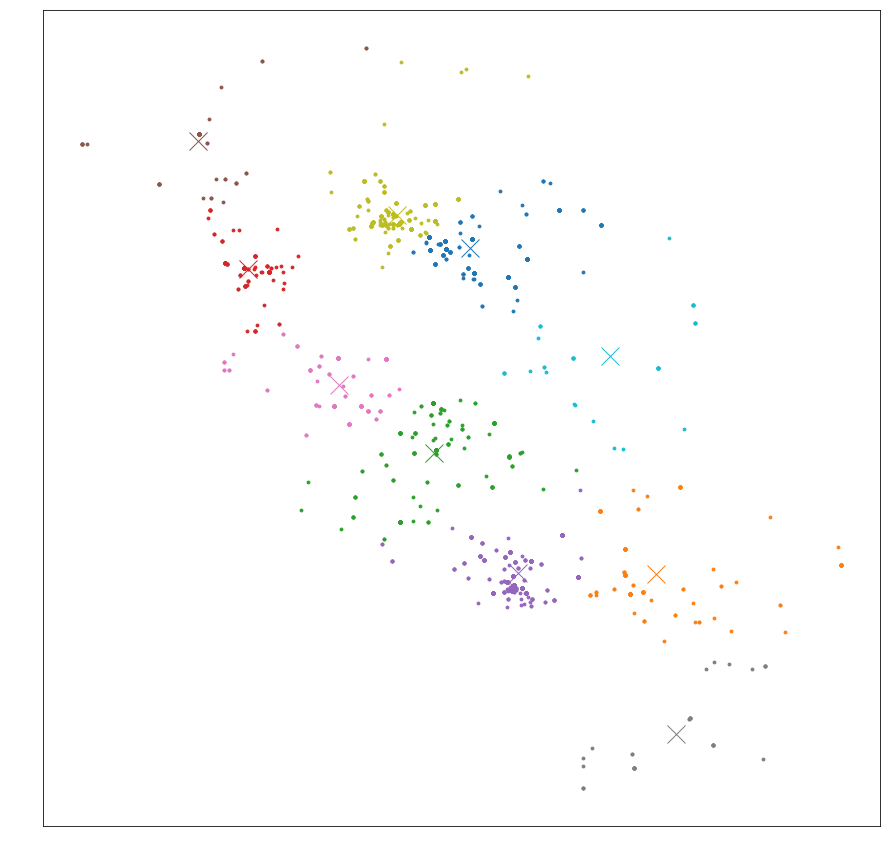

In [1214]:
plt.figure(figsize=(15,15))
for i in range(n):
    cluster = clustered[clustered['cluster'] == i]
    plt.scatter(cluster['longitude'], cluster['latitude'], s=8, cmap='viridis')
    c = centroids.iloc[i]
    plt.plot(c['long'], c['lat'], marker='x', markersize=18)

In [1200]:
fig, ax = plt.subplots(figsize=(15,15))
x = edible_by_species['longitude']
y = edible_by_species['latitude']
# ax.plot(x, y, 'bo')

for i in range(n):
    cluster = clustered[clustered['cluster']==i]
    plt.scatter(cluster['longitude'], cluster['latitude'], s=10, cmap='viridis')
    c = centroids.iloc[i]
    ax.plot(c['long'], c['lat'], marker='*', markersize=18)
    
mplleaflet.display(fig=fig)

In [1205]:
edible_by_species_clustered = pd.concat([edible_by_species, clustered['cluster']],axis=1)
edible_by_species_clustered.head(10)

id          created_at          text_name   latitude   longitude  \
0  24690  2009-08-24 08:54:47  Agaricus augustus  37.769001 -122.483501   
1  238804 2016-05-15 23:48:41  Agaricus augustus  37.772150 -122.447002   
2  318067 2018-05-31 15:48:04  Agaricus augustus  37.512100 -122.349998   
3  56761  2010-10-26 23:57:43  Agaricus augustus  37.780701 -122.514000   
4  26386  2009-10-08 23:05:52  Agaricus augustus  37.750900 -122.489998   
5  28240  2009-11-15 05:08:09  Agaricus augustus  36.990400 -122.058998   
6  71873  2011-07-20 00:09:33  Agaricus augustus  37.777500 -122.511501   
7  325816 2018-08-05 19:41:55  Agaricus augustus  37.769001 -122.483501   
8  163409 2014-04-15 00:29:09  Agaricus augustus  36.994299 -122.058498   
9  57453  2010-10-29 13:58:57  Agaricus augustus  36.990400 -122.058998   

   cluster  
0  3        
1  3        
2  6        
3  3        
4  3        
5  4        
6  3        
7  3        
8  4        
9  4

In [ ]:
cluster_dict = {
    0: 'Watsonville',
    1: 'Berkeley',
    2: 'San Jose',
    3: 'Santa Cruz',
    4: 'Monterey',
    5: 'San Francisco',
    6: 'Fremont',
    7: 'North Bay',
    8: 'Peninsula',
    9: 'Livermore',
}



In [1126]:
edible_clustered_train, edible_clustered_test = get_mushroom_train_test(edible_by_species_clustered, '2016-07-01')
edible_clustered_train.head()
# edible_clustered_train.dtypes

/Users/chris/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/chris/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


id          created_at          text_name   latitude   longitude  \
0  24690  2009-08-24 08:54:47  Agaricus augustus  37.769001 -122.483501   
1  238804 2016-05-15 23:48:41  Agaricus augustus  37.772150 -122.447002   
3  56761  2010-10-26 23:57:43  Agaricus augustus  37.780701 -122.514000   
4  26386  2009-10-08 23:05:52  Agaricus augustus  37.750900 -122.489998   
5  28240  2009-11-15 05:08:09  Agaricus augustus  36.990400 -122.058998   

   cluster grid_code  
0  3        183_78    
1  3        184_82    
3  3        185_75    
4  3        181_78    
5  4        74_121

In [1127]:
edible_clustered_train.dtypes

id            int64         
created_at    datetime64[ns]
text_name     object        
latitude      float64       
longitude     float64       
cluster       int32         
grid_code     object        
dtype: object

In [1128]:
edible_clustered_train['created_at'][0].toordinal()

733643

In [1129]:
# def assign_grid(x):
#     '''
#     Assign grid code using the latitude and longitude of the original dataframe.
#     '''
#     lat_range = (38.4228 - 36.4557) / 275
#     long_range = (-123.2710 - -121.5229) / 175
    
#     return str(math.floor((x[3] - 36.4557) / lat_range)) + '_' + str(math.floor((-123.2710 - x[4] ) / long_range))

# mush_train['grid_code'] = mush_train.apply(assign_grid, axis = 1)

edible_clustered_train['created_at'] = edible_clustered_train['created_at'].map(lambda x: x.toordinal())
edible_clustered_train.head()

/Users/chris/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


id  created_at          text_name   latitude   longitude  cluster  \
0  24690   733643      Agaricus augustus  37.769001 -122.483501  3         
1  238804  736099      Agaricus augustus  37.772150 -122.447002  3         
3  56761   734071      Agaricus augustus  37.780701 -122.514000  3         
4  26386   733688      Agaricus augustus  37.750900 -122.489998  3         
5  28240   733726      Agaricus augustus  36.990400 -122.058998  4         

  grid_code  
0  183_78    
1  184_82    
3  185_75    
4  181_78    
5  74_121

In [1130]:
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()
labels = label_enc.fit_transform(edible_clustered_train['text_name'])
labels

array([ 0,  0,  0, ..., 36, 36, 36])

### Modeling using LogisticRegression

In [1131]:
X_train = edible_clustered_train.copy()
y_train = X_train['text_name']
# y_train = labels

### trying breaking out year, month, and day
# X_train['year'] = X_train.apply(lambda row: row['created_at'].year, axis=1)
# X_train['month'] = X_train.apply(lambda row: row['created_at'].month, axis=1)
# X_train['day'] = X_train.apply(lambda row: row['created_at'].day, axis=1)
###

### trying converting created_at to ordinal
# X_train['created_at'] = X_train.apply(lambda row: row['created_at'].toordinal(), axis=1)
###

X_train = X_train.drop(['id', 'latitude', 'longitude', 'text_name'], axis=1)
# X = pd.get_dummies(X, columns=['text_name'])
X_train.head()

created_at  cluster grid_code
0  733643      3        183_78  
1  736099      3        184_82  
3  734071      3        185_75  
4  733688      3        181_78  
5  733726      4        74_121

In [1132]:
# from datetime import datetime
# date = datetime.strptime(X_train['created_at'], '%Y-%M-%d')
# date
# X_train['created_at'] = X_train.apply(lambda row: row['created_at'].to_ordinal(), axis=1)
# X_train['created_at'] = X_train.apply( 
#      ['created_at'].toordinal()
# X_train.head()

# X_train['year'] = X_train.apply(lambda row: row['created_at'].year, axis=1)
# X_train['month'] = X_train.apply(lambda row: row['created_at'].month, axis=1)
# X_train['day'] = X_train.apply(lambda row: row['created_at'].day, axis=1)
# X_train.head()

In [1133]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
print(cross_val_score(log_reg, X_train, y_train))

[0.07449857 0.06086957 0.06973294]


/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


In [1134]:
# ss = StandardScaler()
# X_train_ss = ss.fit_transform(X_train)
# X_train_ss[0:10]

In [1135]:
# log_reg = LogisticRegression()
# log_reg.fit(X_train_ss, y_train)
# print(cross_val_score(log_reg, X_train_ss, y_train))

In [1136]:
X_test = edible_clustered_test.copy()
X_test['created_at'] = X_test['created_at'].map(lambda x: x.toordinal())
y_test = X_test['text_name']
X_test = X_test.drop(['id', 'text_name', 'latitude', 'longitude'], axis=1)
X_test.head()

created_at  cluster grid_code
2   736845      6        147_92  
7   736911      3        183_78  
14  736206      4        92_114  
49  736205      8        198_103 
72  736255      5        212_65

In [1137]:
y_pred = log_reg.predict(X_test)
# y_pred[0:10]

array(['Clitocybe nuda', 'Clitocybe nuda', 'Clitocybe nuda',
       'Amanita velosa', 'Clitocybe nuda', 'Clitocybe nuda',
       'Clitocybe nuda', 'Amanita velosa', 'Clitocybe nuda',
       'Clitocybe nuda'], dtype=object)

In [934]:
X_test['actual'] = y_test
X_test['preds'] = y_pred
i, j = 0, 0
for index, row in X_test.iterrows():
    if row['actual'] == row['preds']:
        print(row['actual'], "/", row['preds'])
        j += 1
    i += 1
    
print(j, '/', i)

Amanita velosa / Amanita velosa
Amanita velosa / Amanita velosa
Amanita velosa / Amanita velosa
Amanita velosa / Amanita velosa
Amanita velosa / Amanita velosa
Amanita velosa / Amanita velosa
Amanita velosa / Amanita velosa
Amanita velosa / Amanita velosa
Amanita velosa / Amanita velosa
Amanita velosa / Amanita velosa
Amanita velosa / Amanita velosa
Amanita velosa / Amanita velosa
Amanita velosa / Amanita velosa
Amanita velosa / Amanita velosa
Boletus edulis / Boletus edulis
Boletus edulis / Boletus edulis
Clitocybe nuda / Clitocybe nuda
Clitocybe nuda / Clitocybe nuda
Clitocybe nuda / Clitocybe nuda
Clitocybe nuda / Clitocybe nuda
Clitocybe nuda / Clitocybe nuda
Clitocybe nuda / Clitocybe nuda
Clitocybe nuda / Clitocybe nuda
Clitocybe nuda / Clitocybe nuda
Clitocybe nuda / Clitocybe nuda
Clitocybe nuda / Clitocybe nuda
Clitocybe nuda / Clitocybe nuda
Clitocybe nuda / Clitocybe nuda
Clitocybe nuda / Clitocybe nuda
Clitocybe nuda / Clitocybe nuda
Clitocybe nuda / Clitocybe nuda
Panaeolu

### Visualizations

In [1213]:
choice_train = choice_by_year[choice_by_year['created_at'] < '2016-07-01']
choice_test = choice_by_year[choice_by_year['created_at'] >= '2016-07-01']
choice_test.head()

text_name  name_count          created_at  obsv_year
166  Boletus edulis           1          2016-11-13 05:03:08  2016     
168  Boletus regineus         3          2016-11-14 05:22:04  2016     
180  Amanita novinupta        4          2017-02-24 06:45:19  2017     
181  Amanita novinupta group  1          2017-11-19 04:35:57  2017     
182  Boletus edulis           1          2017-12-08 05:38:42  2017

In [ ]:
def mushroom_count_by_year(species_list):
    species_input = '|'.join(species_list)
    # return species_input
    query = "SELECT bay_area_names.text_name, count(bay_area_observations.id) AS name_count, bay_area_observations.created_at, YEAR(bay_area_observations.created_at) AS obsv_year FROM bay_area_names LEFT JOIN bay_area_observations ON bay_area_names.id = bay_area_observations.name_id WHERE bay_area_names.text_name REGEXP ('" + species_input + "') GROUP BY obsv_year, text_name;"
    # return query
    mush_by_species_df = pd.read_sql(query, con=mysql_cn)
    return mush_by_species_df    

choice_by_year = mushroom_count_by_year(choice_mushroom_list)
edible_by_year = mushroom_count_by_year(choice_mushroom_list + edible_mushroom_list + not_choice_mushroom_list)
poisonous_by_year = mushroom_count_by_year(poisonous_mushroom_list)
psychoactive_by_year = mushroom_count_by_year(psychoactive_mushroom_list)
other_by_year = mushroom_count_by_year(other_mushroom_list)

# choice_by_year[choice_by_year['obsv_year'] == 2010].head()
choice_by_year.head()

In [1212]:
def chart_mushroom_counts(mushroom_df, prefix=''):
    df = pd.DataFrame
    plt.figure(figsize=(20, 15))
    # plt.xticks(rotation=90)
    plt.title(prefix + ' Mushroom Counts By Year\n', fontsize='18', color='w')
    # plt.plot(mushroom_df['text_name'].groupby(['obsv_year']).sum())
    df = mushroom_df.groupby(['obsv_year', 'text_name']).sum()['name_count'].unstack()
    plt.plot(df)
    plt.legend(df.columns)

# chart_mushroom_counts(choice_by_year, 'Choice Edible')

In [172]:
# poisonous_by_year.groupby(['obsv_year', 'text_name']).sum()['name_count'].unstack().columns

In [1211]:
# poisonous_by_year
# chart_mushroom_counts(poisonous_by_year, 'Poisonous')

In [1210]:
# chart_mushroom_counts(psychoactive_by_year, 'Psychoactive')

In [1209]:
# chart_mushroom_counts(other_by_year, 'Other')

In [1208]:
def chart_mushroom_counts(mushroom_df):
    plt.figure(figsize=(15, 9))
    plt.xticks(rotation=90)
    plt.title('Mushroom Count By Year\n', fontsize='18', color='w')
    # plt.plot(mushroom_df['text_name'].groupby(['obsv_year']).sum())
    
    plt.plot(mushroom_df['text_name'].groupby(['obsv_year']).count())

# chart_mushroom_counts(choice_by_year)

In [144]:
df_obsv = mush_obsv_df.copy() ##
df_names = mush_names_df.copy()
df_locs = mush_locs_df.copy()
species_list = ['Tuber oregonense', 'Xeromphalina']
obsv_cols=['id', 'created_at', 'location_id', 'is_collection_location', 'where']

# obsv_df = pd.DataFrame(columns=obsv_cols)
# obsv_df = obsv_df.set_index('id')
obsv_df = pd.DataFrame(data=None, columns=mush_obsv_df.columns)

# df_names

for species in species_list:
    temp_df = pd.DataFrame(columns=obsv_cols)
    temp_df = temp_df.set_index('id')

    ### look up name in names table
    mush_name = df_names[df_names['text_name'] == species]
    mush_name_ids = list(mush_name.index.values)

    ### pull observations based on name_ids
    temp_df = df_obsv[df_obsv['name_id'] == mush_name_ids]
    temp_df['species_name'] = species

    # , 'text_name', 'location_name'

    ################ NEED TO RUN .apply() TO ASSIGN LOCATION NAMES/NSEW

    ### pull locations based on location_ids from observations
    # location_ids = obsv['location_id'].values
    # return location_ids
    # locations = df_locs[df_locs.index.values == location_ids]
    # return locations

    obsv_df = pd.concat([obsv_df, temp_df])

df_locs = df_locs.reset_index('id')
#obsv_df = obsv_df.merge(df_locs[['id', 'name', 'north', 'south', 'east', 'west']], left_on='location_id', right_on='id')
#obsv_df

# mush = get_mushrooms_by_species(mush_obsv_df, mush_names_df, mush_locs_df, ['Xeromphalina', 'Tuber oregonense'])


/Users/chris/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/chris/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:35: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



In [145]:
obsv_df['name_id'] = obsv_df['name_id'].astype(int)
obsv_df = obsv_df[['name_id','created_at', 'location_id', 'is_collection_location', 'where']]

In [ ]:
df.apply(lambda row['new']: row[0] + row[1])

In [148]:
df_names[df_names['text_name'].map(lambda x: x in species_list)]

version          created_at          updated_at  user_id  \
id                                                               
5           7 2007-01-10 05:03:37 2018-02-04 16:40:56        1   
1019        3 2007-03-04 07:23:32 2012-01-13 23:58:47        2   

      description_id  rss_log_id  num_views           last_view  rank  \
id                                                                      
5             4954.0     21994.0        856 2018-09-08 17:38:25     9   
1019             NaN     93324.0        542 2018-06-22 13:05:08     4   

             text_name                                 search_name  \
id                                                                   
5         Xeromphalina                 Xeromphalina Kühner & Maire   
1019  Tuber oregonense  Tuber oregonense Trappe, Bonito & P. Rawl.   

                                           display_name  \
id                                                        
5                   **__Xeromphalina__** Kühner & Maire   
1019  **__Tuber oregonense__** Trappe, Bonito & P. R...   

                                        sort_name  \
id                                                  
5                    Xeromphalina  Kühner & Maire   
1019  Tuber oregonense  Trappe, Bonito & P. Rawl.   

                                               citation  deprecated  \
id                                                                    
5     Konrad, P.; Maublanc, A. 1937. Icones Selectae...           0   
1019                      Mycologia 102(5): 1053 (2010)           0   

      synonym_id  correct_spelling_id  \
id                                      
5         6577.0                  NaN   
1019         NaN                  NaN   

                                                  notes  \
id                                                        
5     http://www.indexfungorum.org/names/NamesRecord...   
1019      This species is not listed in Index Fungorum.   

                                         classification  ok_for_export  \
id                                                                       
5     Domain: _Eukarya_\r\nKingdom: _Fungi_\r\nPhylu...              1   
1019                                               None              1   

                         author lifeform  locked  
id                                                
5                Kühner & Maire                0  
1019  Trappe, Bonito & P. Rawl.                0

In [36]:
def get_mushrooms_by_species(df_obsv, df_names, df_locs, species_list, obsv_cols=['id', 'created_at', 'location_id', 'is_collection_location', 'where']):
    # obsv_cols = df_obsv.columns
    obsv_df = pd.DataFrame(columns=obsv_cols)
    obsv_df = obsv_df.set_index('id')

    for species in species_list:
        temp_df = pd.DataFrame(columns=obsv_cols)
        temp_df = temp_df.set_index('id')

        ### look up name in names table
        mush_name = df_names[df_names['text_name'] == species]
        mush_name_ids = list(mush_name.index.values)
        
        ### pull observations based on name_ids
        temp_df = df_obsv[df_obsv['name_id'] == mush_name_ids]
        temp_df['species_name'] = species

        # , 'text_name', 'location_name'
        
        ################ NEED TO RUN .apply() TO ASSIGN LOCATION NAMES/NSEW
        
        ### pull locations based on location_ids from observations
        # location_ids = obsv['location_id'].values
        # return location_ids
        # locations = df_locs[df_locs.index.values == location_ids]
        # return locations

        obsv_df = pd.concat([obsv_df, temp_df])
        # obsv_df = obsv_df.reset_index()

        # obsv_df = pd.merge(obsv_df, df_locs[['name', 'north']], left_on='location_id', left_index=False, right_index=True, how='left')

        # df['alpha_posterior'] = df.apply(lambda row: row['hits'] + 27, axis=1)
        # obsv_df['location_name'] = obsv_df.apply(lambda row: locations.index == row['location_id'])
                
        # obsv_df = pd.concat([obsv_df, obsv])
        # obsv_df['']

    # obsv_df = obsv_df.reset_index('id')
    df_locs = df_locs.reset_index('id')
    obsv_df = obsv_df.merge(df_locs[['id', 'name', 'north', 'south', 'east', 'west']], left_on='location_id', right_on='id')

    
    # obsv_df = obsv_df.join(df_locs[['name', 'north', 'south', 'east', 'west']], on='location_id')
    # obsv_df = obsv_df.join(df_locs, on='location_id')
    # obsv_df = pd.concat([obsv_df, df_locs],axis=1)
    
    return obsv_df

# mush = get_mushrooms_by_species(mush_obsv_df, mush_names_df, mush_locs_df, ['Xeromphalina', 'Tuber oregonense'])
mush = get_mushrooms_by_species(mush_obsv_df, mush_names_df, mush_locs_df, ['Tuber oregonense', 'Xeromphalina'])
mush

/Users/chris/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/chris/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat

### Close MySQL connection

In [ ]:
mysql_cn.close()